In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/testImages_artphoto_final.zip" 

Archive:  /content/drive/MyDrive/testImages_artphoto_final.zip
  inflating: testImages_artphoto (1)/.DS_Store  
   creating: testImages_artphoto (1)/Amusement/
  inflating: testImages_artphoto (1)/Amusement/amusement_0487.jpg  
  inflating: testImages_artphoto (1)/Amusement/amusement_0488.jpg  
  inflating: testImages_artphoto (1)/Amusement/amusement_0489.jpg  
  inflating: testImages_artphoto (1)/Amusement/amusement_0490.jpg  
  inflating: testImages_artphoto (1)/Amusement/amusement_0491.jpg  
  inflating: testImages_artphoto (1)/Amusement/amusement_0492.jpg  
  inflating: testImages_artphoto (1)/Amusement/amusement_0493.jpg  
  inflating: testImages_artphoto (1)/Amusement/amusement_0494.jpg  
  inflating: testImages_artphoto (1)/Amusement/amusement_0495.jpg  
  inflating: testImages_artphoto (1)/Amusement/amusement_0496.jpg  
  inflating: testImages_artphoto (1)/Amusement/amusement_0497.jpg  
  inflating: testImages_artphoto (1)/Amusement/amusement_0498.jpg  
  inflating: testImages_

In [ ]:
data_dir = "/content/testImages_artphoto (1)"

dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))


In [ ]:
img, label = dataset[7]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [ ]:
print("Following classes are there : \n",dataset.classes)

Following classes are there : 
 ['Amusement', 'Anger', 'Awe', 'Contenment', 'disgust', 'excitement', 'fear', 'sad']


Label : sad


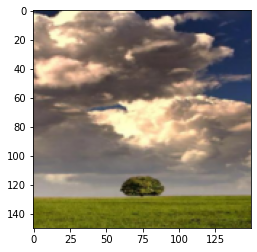

In [ ]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

display_img(*dataset[805])

In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 32
val_size = 80
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 726
Length of Validation Data : 80


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [42]:
num_epochs = 35
num_classes = 8
learning_rate = 0.0001

In [43]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16,kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(20736, 128)
        self.fc2 = nn.Linear(128,8)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [45]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=20736, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=8, bias=True)
)


In [46]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_dl:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in val_dl:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_dl.sampler)
    valid_loss = valid_loss/len(val_dl.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 	Training Loss: 2.072391 	Validation Loss: 2.063932
Epoch: 2 	Training Loss: 2.060660 	Validation Loss: 2.063835
Epoch: 3 	Training Loss: 2.041528 	Validation Loss: 2.052838
Epoch: 4 	Training Loss: 2.039249 	Validation Loss: 2.044638
Epoch: 5 	Training Loss: 2.027434 	Validation Loss: 2.045170
Epoch: 6 	Training Loss: 2.031747 	Validation Loss: 2.025589
Epoch: 7 	Training Loss: 2.000112 	Validation Loss: 2.022249
Epoch: 8 	Training Loss: 2.001785 	Validation Loss: 2.009911
Epoch: 9 	Training Loss: 1.990959 	Validation Loss: 2.003765
Epoch: 10 	Training Loss: 1.995317 	Validation Loss: 2.006852
Epoch: 11 	Training Loss: 1.985059 	Validation Loss: 1.990107
Epoch: 12 	Training Loss: 1.961076 	Validation Loss: 1.993095
Epoch: 13 	Training Loss: 1.953468 	Validation Loss: 1.992265
Epoch: 14 	Training Loss: 1.958873 	Validation Loss: 1.994701
Epoch: 15 	Training Loss: 1.944447 	Validation Loss: 1.980955
Epoch: 16 	Training Loss: 1.941715 	Validation Loss: 1.975767
Epoch: 17 	Traini

In [50]:
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Accuracy of the model: 23.75 %


In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params 

1329840

In [ ]:
pytorch_total_params1 = sum(p.numel() for p in model.parameters())
pytorch_total_params1 

1328672

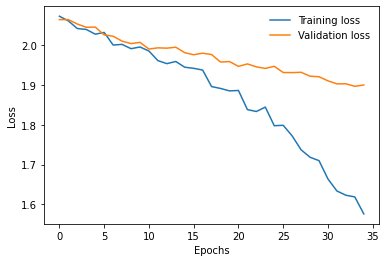

In [49]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)